# Análisis Comparativo: PINNs vs. Diferencias Finitas para la Ecuación de Calor 2D

## Sección 0: Definición del Problema y Configuración

### Descripción de la EDP, Dominio y Condiciones

La ecuación de calor bidimensional dependiente del tiempo se define como:

$$\frac{\partial T}{\partial t} = \alpha \left( \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} \right)$$

Donde:
- $T(x, y, t)$ es la temperatura en la posición $(x, y)$ en el tiempo $t$.
- $\alpha$ es la difusividad térmica del material.

**Dominio:**
- Espacial: $x \in [0, 1]$, $y \in [0, 1]$
- Temporal: $t \in [0, 1]$

**Condiciones de Frontera (Dirichlet):**
- $T(0, y, t) = 0$
- $T(1, y, t) = 0$
- $T(x, 0, t) = 0$
- $T(x, 1, t) = 0$

**Condición Inicial:**
- $T(x, y, 0) = \sin(\pi x) \sin(\pi y)$

### Parámetros Globales

In [52]:
# Parámetros físicos y de simulación
ALPHA = 0.01      # Difusividad térmica
X_MIN, X_MAX = 0.0, 1.0
Y_MIN, Y_MAX = 0.0, 1.0
T_MIN, T_MAX = 0.0, 1.0 # Tiempo inicial y final

# Parámetros de la malla (para FD y predicción PINN)
NX = 51           # Número de puntos en x
NY = 51           # Número de puntos en y
NT_FD = 2000      # Número de pasos de tiempo para FD (estimado para estabilidad)

# Parámetros para la PINN
PINN_EPOCHS = 20000 # Idealmente >50000
PINN_LR = 1e-3
PINN_NUM_DOMAIN = 5000
PINN_NUM_BOUNDARY = 500
PINN_NUM_INITIAL = 500
PINN_LAYERS = [3] + [32] * 4 + [1] # [t, x, y] -> [T]

### Solución Analítica

In [35]:
import numpy as np

def T_analitica_func(x, y, t, alpha=ALPHA):
    """Calcula la solución analítica de la ecuación de calor 2D."""
    return np.exp(-2 * np.pi**2 * alpha * t) * np.sin(np.pi * x) * np.sin(np.pi * y)

### Importaciones Necesarias

In [36]:
import deepxde as dde
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Configuración para DeepXDE (si es necesario, ej. backend)
# dde.config.set_default_backend("pytorch") # o "tensorflow" o "jax"

print(f"Usando backend de DeepXDE: {dde.backend.backend_name}")

Usando backend de DeepXDE: tensorflow.compat.v1


## Sección 1: Método con Red Neuronal Informada por la Física (PINN)

In [53]:
# 1. Definición de la EDP y Geometría para PINN
def pde(x, T):
    """Define la Ecuación Diferencial Parcial (EDP) para la ecuación de calor."""
    dT_dt = dde.grad.jacobian(T, x, i=0, j=0)
    dT_dxx = dde.grad.hessian(T, x, i=0, j=1)
    dT_dyy = dde.grad.hessian(T, x, i=0, j=2)
    return dT_dt - ALPHA * (dT_dxx + dT_dyy)

# Dominio geométrico y temporal
geom = dde.geometry.Rectangle([X_MIN, Y_MIN], [X_MAX, Y_MAX])
timedomain = dde.geometry.TimeDomain(T_MIN, T_MAX)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Condiciones de frontera (BC)
def boundary_func(x, on_boundary):
    return on_boundary and not (np.isclose(x[0], T_MAX))

bc_zeros = dde.icbc.DirichletBC(
    geomtime,
    lambda x: 0.0, # T = 0 en las fronteras
    boundary_func
)

# Condición inicial (IC)
def initial_condition_func(x):
    return np.sin(np.pi * x[:, 1:2]) * np.sin(np.pi * x[:, 2:3])

ic = dde.icbc.IC(
    geomtime,
    initial_condition_func,
    lambda _, on_initial: on_initial
)

# Definición del problema de datos para DeepXDE
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_zeros, ic],
    num_domain=PINN_NUM_DOMAIN,
    num_boundary=PINN_NUM_BOUNDARY,
    num_initial=PINN_NUM_INITIAL
)

# 2. Construcción y entrenamiento de la PINN
net = dde.nn.FNN(PINN_LAYERS, "tanh", "Glorot normal")
model = dde.Model(data, net)

# Compilar el modelo especificando el optimizador y la tasa de aprendizaje
model.compile("adam", lr=PINN_LR)

# Entrenamiento
print("Iniciando entrenamiento de la PINN...")
start_time_pinn = time.time()
losshistory, train_state = model.train(epochs=PINN_EPOCHS)
end_time_pinn = time.time()
tiempo_pinn = end_time_pinn - start_time_pinn
print(f"Entrenamiento de la PINN completado en {tiempo_pinn:.2f} segundos.")

# --- INICIO DE LA CORRECCIÓN ---

# Guardar historial de pérdida
# En lugar de .epoch, se usa .steps
loss_pinn_epochs = losshistory.steps 
# Usamos np.sum() para sumar las componentes de la pérdida (pde, ic, bc)
loss_pinn_values = np.sum(losshistory.loss_train, axis=1)

# --- FIN DE LA CORRECCIÓN ---

Compiling model...
Building feed-forward neural network...
'build' took 0.050055 s

'compile' took 0.537541 s

Iniciando entrenamiento de la PINN...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.09e-03, 3.38e-02, 5.83e-02]    [2.09e-03, 3.38e-02, 5.83e-02]    []  
1000      [1.82e-06, 1.16e-06, 5.27e-07]    [1.82e-06, 1.16e-06, 5.27e-07]    []  
2000      [3.64e-07, 2.30e-07, 1.13e-07]    [3.64e-07, 2.30e-07, 1.13e-07]    []  
3000      [1.18e-07, 1.00e-07, 3.14e-08]    [1.18e-07, 1.00e-07, 3.14e-08]    []  
4000      [8.09e-08, 3.73e-08, 1.58e-08]    [8.09e-08, 3.73e-08, 1.58e-08]    []  
5000      [5.82e-08, 1.35e-08, 7.73e-09]    [5.82e-08, 1.35e-08, 7.73e-09]    []  
6000      [4.15e-08, 7.27e-09, 2.72e-09]    [4.15e-08, 7.27e-09, 2.72e-09]    []  
7000      [3.05e-08, 4.89e-09, 1.49e-09]    [3.05e-08, 4.89e-09, 1.49e-09]    []  
8000      [1.04e-04, 3.86e-05, 3.74e-05]    [1.04e-04, 3.86e-05, 3.74e-05]    

### Resultados de la PINN

In [54]:
# Preparar la malla para la predicción en t = T_MAX
x_space = np.linspace(X_MIN, X_MAX, NX)
y_space = np.linspace(Y_MIN, Y_MAX, NY)
X_grid, Y_grid = np.meshgrid(x_space, y_space)

# Puntos de predicción (t, x, y) para el tiempo final T_MAX
t_final_flat = np.full_like(X_grid.flatten(), T_MAX)
x_flat = X_grid.flatten()
y_flat = Y_grid.flatten()

prediction_points = np.vstack((t_final_flat, x_flat, y_flat)).T

# Predicción con la PINN entrenada
T_pinn_flat = model.predict(prediction_points)
T_pinn = T_pinn_flat.reshape(NX, NY)

# Calcular solución analítica en la misma malla para comparación
T_analitica_final = T_analitica_func(X_grid, Y_grid, T_MAX)

print("Predicción de la PINN y cálculo de la solución analítica en t=T_MAX completados.")

Predicción de la PINN y cálculo de la solución analítica en t=T_MAX completados.


### Visualización (Sección 1)

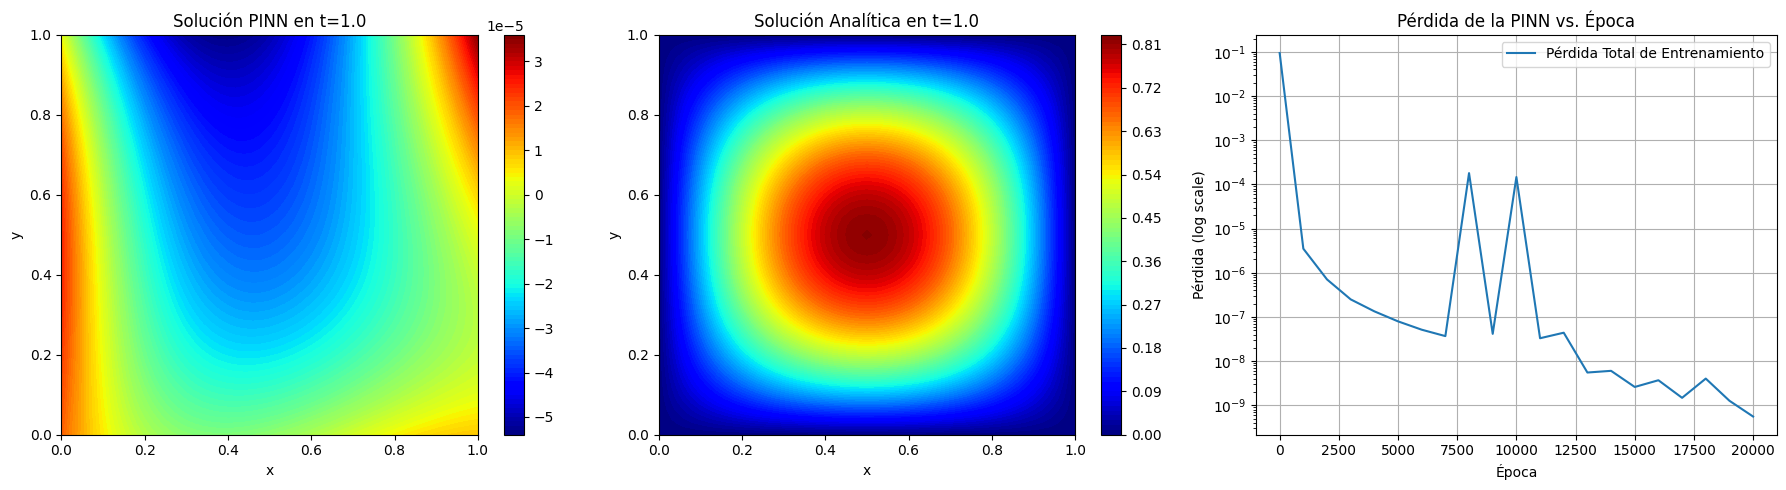

In [55]:
fig_pinn = plt.figure(figsize=(18, 5))

# 1. Mapa de calor de la Solución Numérica (PINN)
ax1 = fig_pinn.add_subplot(131)
contour_pinn = ax1.contourf(X_grid, Y_grid, T_pinn, levels=100, cmap=cm.jet)
fig_pinn.colorbar(contour_pinn, ax=ax1)
ax1.set_title(f'Solución PINN en t={T_MAX}')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# 2. Mapa de calor de la Solución Analítica
ax2 = fig_pinn.add_subplot(132)
contour_analitica_pinn = ax2.contourf(X_grid, Y_grid, T_analitica_final, levels=100, cmap=cm.jet)
fig_pinn.colorbar(contour_analitica_pinn, ax=ax2)
ax2.set_title(f'Solución Analítica en t={T_MAX}')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

# 3. Gráfico de Pérdida (Loss) vs. Época
ax3 = fig_pinn.add_subplot(133)
ax3.plot(loss_pinn_epochs, loss_pinn_values, label='Pérdida Total de Entrenamiento')
ax3.set_yscale('log')
ax3.set_title('Pérdida de la PINN vs. Época')
ax3.set_xlabel('Época')
ax3.set_ylabel('Pérdida (log scale)')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

## Sección 2: Método Clásico (Diferencias Finitas)

In [40]:
# Implementación del Solucionador de Diferencias Finitas (FTCS)

# Parámetros para Diferencias Finitas
dx = (X_MAX - X_MIN) / (NX - 1)
dy = (Y_MAX - Y_MIN) / (NY - 1)
dt = (T_MAX - T_MIN) / NT_FD

# Constante de estabilidad (asegurarse de que sea < 0.25 para 2D FTCS)
stability_factor = ALPHA * dt * (1/dx**2 + 1/dy**2)
print(f"Factor de estabilidad para FD (FTCS): {stability_factor:.4f}")
if stability_factor >= 0.25:
    print("¡Advertencia! El esquema FTCS puede ser inestable con estos parámetros.")
    print(f"Se recomienda dt <= {0.24 / (ALPHA * (1/dx**2 + 1/dy**2)):.6f}")

# Inicializar la malla
T_fd = np.zeros((NX, NY))
x_fd_space = np.linspace(X_MIN, X_MAX, NX)
y_fd_space = np.linspace(Y_MIN, Y_MAX, NY)
X_fd_grid, Y_fd_grid = np.meshgrid(x_fd_space, y_fd_space)

# Aplicar condición inicial T(x,y,0)
T_fd = T_analitica_func(X_fd_grid, Y_fd_grid, 0)

T_fd_new = np.copy(T_fd)

print("Iniciando simulación con Diferencias Finitas (FTCS)...")
start_time_fd = time.time()

# Bucle temporal FTCS
for n in range(NT_FD):
    # Vectorización para eficiencia
    T_fd_new[1:-1, 1:-1] = T_fd[1:-1, 1:-1] + ALPHA * dt * (
        (T_fd[2:, 1:-1] - 2*T_fd[1:-1, 1:-1] + T_fd[:-2, 1:-1]) / dx**2 + 
        (T_fd[1:-1, 2:] - 2*T_fd[1:-1, 1:-1] + T_fd[1:-1, :-2]) / dy**2
    )
    T_fd = np.copy(T_fd_new)

end_time_fd = time.time()
tiempo_fd = end_time_fd - start_time_fd
print(f"Simulación con Diferencias Finitas completada en {tiempo_fd:.2f} segundos.")

Factor de estabilidad para FD (FTCS): 0.0250
Iniciando simulación con Diferencias Finitas (FTCS)...
Simulación con Diferencias Finitas completada en 0.08 segundos.


### Resultados de FD

In [41]:
# La solución T_fd ya contiene el resultado en t=T_MAX
# Calcular solución analítica en la misma malla para comparación
T_analitica_final_fd = T_analitica_func(X_fd_grid, Y_fd_grid, T_MAX)

print("Solución de Diferencias Finitas y cálculo de la solución analítica en t=T_MAX completados.")

Solución de Diferencias Finitas y cálculo de la solución analítica en t=T_MAX completados.


### Visualización (Sección 2)

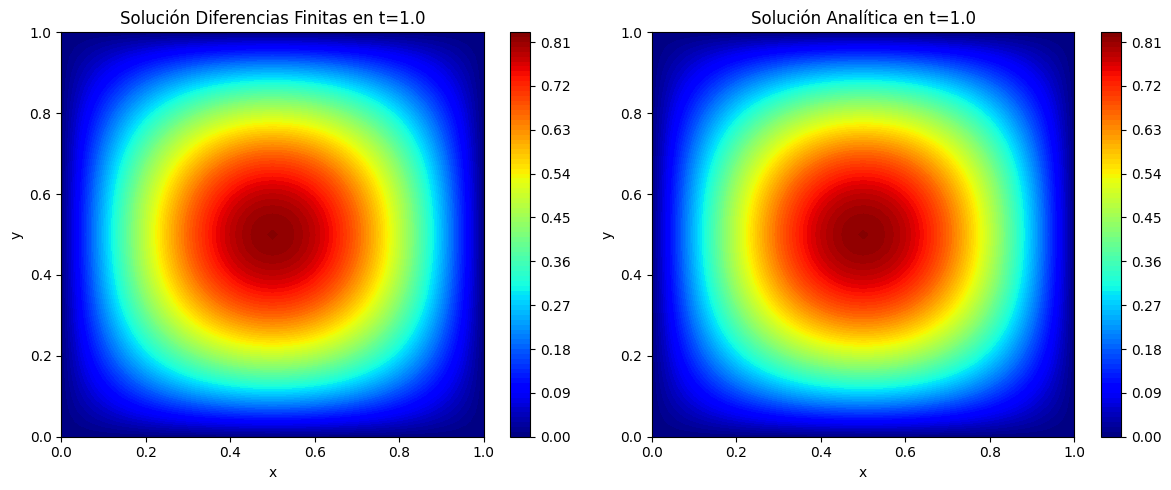

In [42]:
fig_fd = plt.figure(figsize=(12, 5))

# 1. Mapa de calor de la Solución Numérica (Diferencias Finitas)
ax_fd1 = fig_fd.add_subplot(121)
contour_fd = ax_fd1.contourf(X_fd_grid, Y_fd_grid, T_fd, levels=100, cmap=cm.jet)
fig_fd.colorbar(contour_fd, ax=ax_fd1)
ax_fd1.set_title(f'Solución Diferencias Finitas en t={T_MAX}')
ax_fd1.set_xlabel('x')
ax_fd1.set_ylabel('y')

# 2. Mapa de calor de la Solución Analítica
ax_fd2 = fig_fd.add_subplot(122)
contour_analitica_fd = ax_fd2.contourf(X_fd_grid, Y_fd_grid, T_analitica_final_fd, levels=100, cmap=cm.jet)
fig_fd.colorbar(contour_analitica_fd, ax=ax_fd2)
ax_fd2.set_title(f'Solución Analítica en t={T_MAX}')
ax_fd2.set_xlabel('x')
ax_fd2.set_ylabel('y')

plt.tight_layout()
plt.show()

## Sección 3: Análisis Comparativo y Conclusiones

### Comparación Cuantitativa

In [56]:
print("--- Tiempos de Ejecución ---")
print(f"Tiempo de entrenamiento/ejecución PINN: {tiempo_pinn:.2f} segundos")
print(f"Tiempo de simulación Diferencias Finitas: {tiempo_fd:.2f} segundos")

# Error Absoluto Medio (MAE)
mae_pinn = np.mean(np.abs(T_pinn - T_analitica_final))
mae_fd = np.mean(np.abs(T_fd - T_analitica_final_fd))

print("\n--- Error Absoluto Medio (MAE) en t=T_MAX ---")
print(f"MAE PINN vs Analítica: {mae_pinn:.6f}")
print(f"MAE FD vs Analítica:   {mae_fd:.6f}")

if mae_pinn < mae_fd:
    print("\nLa PINN fue más precisa en este caso.")
elif mae_fd < mae_pinn:
    print("\nLas Diferencias Finitas fueron más precisas en este caso.")
else:
    print("\nAmbos métodos tuvieron una precisión similar.")

--- Tiempos de Ejecución ---
Tiempo de entrenamiento/ejecución PINN: 632.55 segundos
Tiempo de simulación Diferencias Finitas: 0.08 segundos

--- Error Absoluto Medio (MAE) en t=T_MAX ---
MAE PINN vs Analítica: 0.319574
MAE FD vs Analítica:   0.000018

Las Diferencias Finitas fueron más precisas en este caso.


### Visualización Comparativa Final

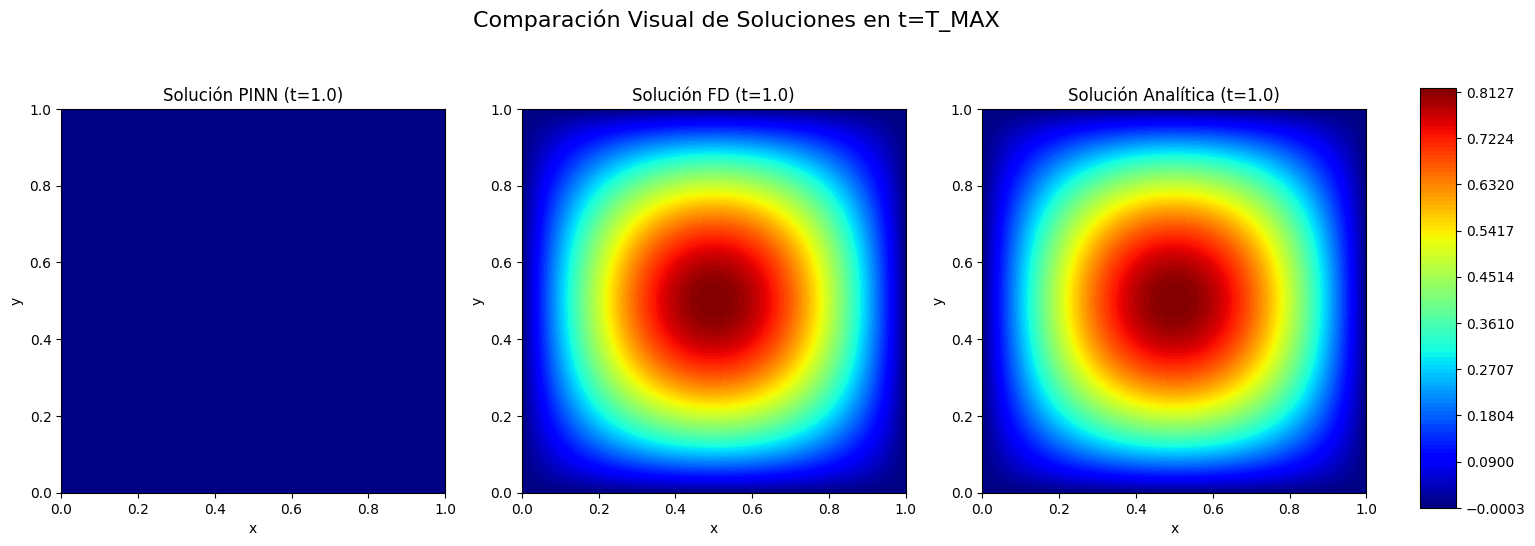

In [46]:
# Determinar los límites globales para la barra de color
min_val = min(T_pinn.min(), T_fd.min(), T_analitica_final.min())
max_val = max(T_pinn.max(), T_fd.max(), T_analitica_final.max())

fig_comp = plt.figure(figsize=(18, 6))
levels_comp = np.linspace(min_val, max_val, 101)

# 1. Solución Numérica (PINN)
ax_c1 = fig_comp.add_subplot(131)
cp1 = ax_c1.contourf(X_grid, Y_grid, T_pinn, levels=levels_comp, cmap=cm.jet, vmin=min_val, vmax=max_val)
ax_c1.set_title(f'Solución PINN (t={T_MAX})')
ax_c1.set_xlabel('x')
ax_c1.set_ylabel('y')
ax_c1.set_aspect('equal')

# 2. Solución Numérica (Diferencias Finitas)
ax_c2 = fig_comp.add_subplot(132)
cp2 = ax_c2.contourf(X_fd_grid, Y_fd_grid, T_fd, levels=levels_comp, cmap=cm.jet, vmin=min_val, vmax=max_val)
ax_c2.set_title(f'Solución FD (t={T_MAX})')
ax_c2.set_xlabel('x')
ax_c2.set_ylabel('y')
ax_c2.set_aspect('equal')

# 3. Solución Analítica
ax_c3 = fig_comp.add_subplot(133)
cp3 = ax_c3.contourf(X_grid, Y_grid, T_analitica_final, levels=levels_comp, cmap=cm.jet, vmin=min_val, vmax=max_val)
ax_c3.set_title(f'Solución Analítica (t={T_MAX})')
ax_c3.set_xlabel('x')
ax_c3.set_ylabel('y')
ax_c3.set_aspect('equal')

# Añadir una única barra de color para todos los subplots
fig_comp.subplots_adjust(right=0.85)
cbar_ax = fig_comp.add_axes([0.88, 0.15, 0.02, 0.7])
fig_comp.colorbar(cp1, cax=cbar_ax)

plt.suptitle('Comparación Visual de Soluciones en t=T_MAX', fontsize=16)
plt.show()

### Discusión: Fortalezas y Desventajas (Análisis Cualitativo)

Basándote en los resultados obtenidos (tiempo, error, visualización), discute las fortalezas y debilidades de cada enfoque.

**Precisión:**
- *(Comentario sobre qué método fue más preciso según el MAE. Por ejemplo: "El método de [PINN/Diferencias Finitas] mostró un MAE de [valor_MAE] que fue [menor/mayor] que el MAE de [valor_MAE_otro_metodo] para el método de [Diferencias Finitas/PINN]. Esto sugiere que [método] fue [más/menos] preciso para la configuración probada.")*

**Rendimiento:**
- *(Comentario sobre qué método fue más rápido y por qué podría serlo. Por ejemplo: "El entrenamiento de la PINN tomó [tiempo_PINN] segundos, mientras que la simulación de Diferencias Finitas tomó [tiempo_FD] segundos. [PINN/FD] fue significativamente [más rápido/más lento]. La diferencia en velocidad puede atribuirse a [razones, ej. overhead del framework de deep learning vs. bucles de Python, complejidad del entrenamiento vs. cálculo iterativo directo, paralelización, etc.]. Para PINNs, el tiempo de inferencia (predicción) después del entrenamiento es usualmente muy rápido, aunque el entrenamiento puede ser costoso.")*

**Complejidad de Implementación:**
- *(Comentario breve sobre la diferencia en el código para implementar cada método. Por ejemplo: "La implementación de Diferencias Finitas requirió escribir explícitamente los bucles de discretización y actualización (aunque aquí se ha vectorizado para mejorar el rendimiento). La PINN, utilizando el framework DeepXDE, abstrae gran parte de la implementación de la red neuronal y el optimizador, permitiendo al usuario enfocarse más en la definición de la PDE, el dominio y las condiciones de frontera. Sin embargo, la configuración y el ajuste de hiperparámetros de una PINN pueden introducir su propia complejidad.")*

**Flexibilidad (Punto clave para PINNs):**
- *(Menciona que, aunque en este problema de dominio simple no se explota, una fortaleza de las PINNs es que no dependen de una malla (mesh-free) y pueden teóricamente manejar geometrías complejas o problemas con condiciones de borde poco definidas con mayor facilidad que los métodos clásicos. Por ejemplo: "Aunque este problema utiliza un dominio rectangular simple donde los métodos de Diferencias Finitas son efectivos, una ventaja inherente de las PINNs es su naturaleza libre de malla (mesh-free). Esto significa que pueden, en teoría, adaptarse más fácilmente a geometrías complejas, dimensiones más altas, o problemas donde definir una malla adecuada es complicado. Además, las PINNs pueden incorporar datos dispersos o ruidosos de manera más natural y pueden ser más robustas para problemas con condiciones de frontera complejas o mal definidas, ya que las condiciones se incorporan como términos en la función de pérdida.")*